In [796]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import statistics
#import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests
nan=np.nan

In [797]:
DBGmode = 0
#st_date = '2020-7-1'
#en_date = '2020-9-11'
WritetoFile = 0

pd.set_option('display.max_rows', 15)
ticker = 'MSFT'
st_date = '2019-9-11'
en_date = '2020-9-11'

timestep=5
TrainPCT=0.9

ADDUS10Y = 0

ADDXMA = 1
xmasmall=7
xmalong=21

ADDRSI = 0
RSIwindow=7

In [798]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [799]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-799-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [800]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [801]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [802]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [803]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [804]:
#**** Define New Column Label here
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [805]:
#**** ADD New Column Data here
datastock['Close']=closes
#datastock['Volume']=vols

if DBGmode == 1:
    datastock

In [806]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [807]:
print('Total Stock Rows = ', len(datastock))
print('Total US10Y Rows = ', len(us10y_data))

if ADDUS10Y==1:
    #****APPEND US10Y data here to a separate column in a new dataframe
    data=pd.concat([datastock, us10y_data], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data['US10Y'].fillna(method='ffill', inplace=True)

else:
    data=datastock
    
data

Total Stock Rows =  254
Total US10Y Rows =  251


,Close
Date,
2019-09-11T00:00:00.000Z,136.12
2019-09-12T00:00:00.000Z,137.52
2019-09-13T00:00:00.000Z,137.32
2019-09-16T00:00:00.000Z,136.33
2019-09-17T00:00:00.000Z,137.39
...,...
2020-09-04T00:00:00.000Z,214.25
2020-09-08T00:00:00.000Z,202.66
2020-09-09T00:00:00.000Z,211.29


In [808]:
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #xmasmall=5
    #xmalong=9
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=smasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=smalong).mean()

    #Enter EMA Data - defined at the top
    #xmasmall=7
    #xmalong=14
    data['Close-XMA'+str(xmasmall)] = data.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data['Close-XMA'+str(xmalong)] = data.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow=xmalong
    data.drop(data.index[0:droprow], inplace = True)

In [809]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [810]:
#Add RSI here
if ADDRSI == 1:
    data['Close-RSI'+str(RSIwindow)] = computeRSI(data['Close'], RSIwindow)
    data.drop(data.index[0:RSIwindow], inplace = True)

In [811]:
data_noofcols = len(data.columns)
print('Number of data columns = ', data_noofcols)

Number of data columns =  3


In [812]:
data

,Close,Close-XMA7,Close-XMA21
Date,,,
2019-10-10T00:00:00.000Z,139.10,137.694406,137.525040
2019-10-11T00:00:00.000Z,139.68,138.190804,137.720946
2019-10-14T00:00:00.000Z,139.55,138.530603,137.887223
2019-10-15T00:00:00.000Z,141.57,139.290452,138.222021
2019-10-16T00:00:00.000Z,140.41,139.570339,138.420928
...,...,...,...
2020-09-04T00:00:00.000Z,214.25,221.073119,217.425978
2020-09-08T00:00:00.000Z,202.66,216.469839,216.083617
2020-09-09T00:00:00.000Z,211.29,215.174879,215.647833


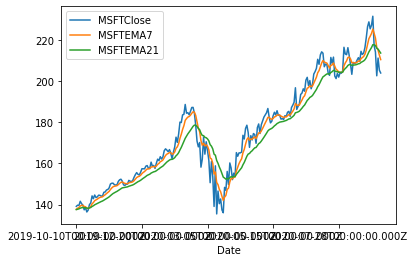

In [813]:
plt.figure()
data['Close'].plot(label=ticker+'Close')
if ADDXMA==1:
    data['Close-XMA'+str(xmasmall)].plot(label=ticker+'EMA'+str(xmasmall))
    data['Close-XMA'+str(xmalong)].plot(label=ticker+'EMA'+str(xmalong))
plt.legend()
if ADDUS10Y==1:
    data['US10Y'].plot(secondary_y=True, label='US10Y')
plt.legend()
#plt.plot(data['Close'], label=ticker+' Closes')
#plt.plot(data['US10Y'], label='US10Y')
plt.show()

No handles with labels found to put in legend.


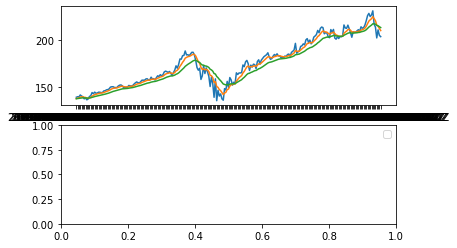

In [814]:
fig, axs = plt.subplots(2,1)
axs[0].plot(data['Close'], label=ticker+' Closes')
if ADDXMA==1:
    axs[0].plot(data['Close-XMA'+str(xmasmall)], label=ticker+' Close-ema'+str(xmasmall))
    axs[0].plot(data['Close-XMA'+str(xmalong)], label=ticker+' Close-ema'+str(xmalong))
    plt.legend()
if ADDRSI==1:
    axs[1].plot(data['Close-RSI'+str(RSIwindow)], label=ticker+' Close-rsi'+str(RSIwindow))
    plt.legend()
plt.show()

In [815]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print('Length of scaled_data = ', len(scaled_data))
print(scaled_data)

Length of scaled_data =  233
[[0.03824171 0.         0.        ]
 [0.04426894 0.0056622  0.0024408 ]
 [0.04291801 0.00953813 0.00451246]
 [0.06390938 0.01820539 0.00868373]
 [0.05185493 0.02139793 0.01116192]
 [0.04437286 0.02173916 0.01259933]
 [0.02067962 0.01549335 0.01132363]
 [0.03127923 0.01371766 0.01131921]
 [0.00987218 0.00651152 0.00898194]
 [0.01891302 0.00358784 0.00784255]
 [0.0469708  0.0090945  0.00986488]
 [0.0551803  0.01547729 0.01259814]
 [0.09113582 0.03013105 0.01900187]
 [0.07700301 0.03724314 0.02328304]
 [0.09550036 0.04765313 0.02919112]
 [0.08261457 0.05192458 0.03315763]
 [0.08625169 0.05612625 0.03715997]
 [0.09487686 0.06164436 0.04173855]
 [0.0939416  0.06552629 0.04579896]
 [0.08978489 0.06729709 0.04903719]
 [0.09186324 0.06919551 0.05220756]
 [0.10952925 0.07546712 0.0570152 ]
 [0.11108802 0.08059856 0.06155568]
 [0.12106412 0.08718472 0.06677073]
 [0.12355814 0.09280873 0.07178352]
 [0.13135197 0.09916547 0.07719008]
 [0.15120025 0.10937965 0.08426848]

In [816]:
train_length = int(len(scaled_data) * TrainPCT)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print('scaled_data length =', len(scaled_data))
    print('train_length = ', train_length)
    print('test_length = ', test_length)
    print(train_data)
    print(test_data)

In [817]:
def create_dataset(dataset, noofcols, timestep=1):
    data_x, data_y = [], []
    #for i in range(len(dataset) - timestep - 1):
        #data_x.append(dataset[i:(i+timestep),0])
        #data_y.append(dataset[i+timestep,0])
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:noofcols])
        data_y.append(dataset[i+timestep,0])
    return np.array(data_x), np.array(data_y)

In [818]:
train_x, train_y = create_dataset(train_data, data_noofcols, timestep)
test_x, test_y = create_dataset(test_data, data_noofcols, timestep)

if DBGmode == 1:
    print(test_x)

In [819]:
if DBGmode == 1:
    print(test_y)

In [820]:
if DBGmode == 1:
    print('train_x shape = ', train_x.shape)
    print('test_x shape = ', test_x.shape)
    print('train_y shape = ', train_y.shape)
    print('test_y shape = ', test_y.shape)

In [821]:
#train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[data_noofcols]))
#test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[data_noofcols]))

#Minimum 2
#train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[2]))
#test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[2]))

if DBGmode == 1:
    print(train_x)

In [822]:
model = Sequential()
#model.add(LSTM(256, input_shape=(1,data_noofcols)))
model.add(LSTM(256, input_shape=(timestep,data_noofcols)))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
#model.add(Dense(6, activation='relu'))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 256)               266240    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________
None


In [823]:
model.fit(train_x, train_y, epochs=3, batch_size=1, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/3
204/204 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.0049
Epoch 2/3
204/204 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.0049
Epoch 3/3
204/204 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.0049
Keras model loss =  0.004754268564283848
Keras model accuracy =  0.0049019609577953815


In [824]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [825]:
# create empty table with data_noofcols fields
train_predictions_like = np.zeros(shape=(len(train_predictions), data_noofcols) )
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), data_noofcols) )
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]

In [826]:
if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [827]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[0:len(train_predictions)] = train_predictions

In [828]:
if DBGmode==1:
    print(test_predictions)

In [829]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+timestep:len(scaled_data)-timestep] = test_predictions

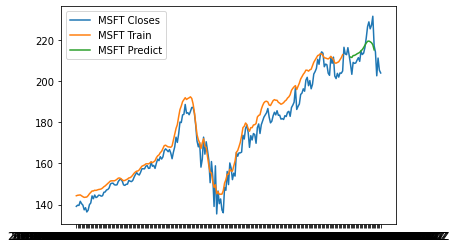

In [830]:
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train')
plt.plot(test_predict_plot, label = ticker+' Predict')
plt.legend()
plt.show()

In [831]:
print('Number of data[Close] rows = ', len(data['Close']))
print('Length of Train data = ', len(train_predictions))
print('Length of test data = ', len(test_predictions))

Number of data[Close] rows =  233
Length of Train data =  204
Length of test data =  19


In [832]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data

,Close,Close-XMA7,Close-XMA21,AITrain,AITest
Date,,,,,
2019-10-10T00:00:00.000Z,139.10,137.694406,137.525040,144.264970,NaN
2019-10-11T00:00:00.000Z,139.68,138.190804,137.720946,144.491541,NaN
2019-10-14T00:00:00.000Z,139.55,138.530603,137.887223,144.571991,NaN
2019-10-15T00:00:00.000Z,141.57,139.290452,138.222021,144.667936,NaN
2019-10-16T00:00:00.000Z,140.41,139.570339,138.420928,144.205872,NaN
...,...,...,...,...,...
2020-09-04T00:00:00.000Z,214.25,221.073119,217.425978,NaN,NaN
2020-09-08T00:00:00.000Z,202.66,216.469839,216.083617,NaN,NaN
2020-09-09T00:00:00.000Z,211.29,215.174879,215.647833,NaN,NaN


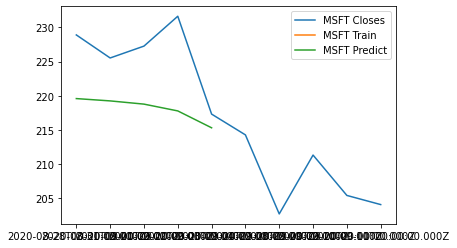

In [833]:
plt.plot(data.Close[-timestep-5:], label = ticker+' Closes')
plt.plot(train_predict_plot[-timestep-5:], label = ticker+' Train')
plt.plot(test_predict_plot[-timestep-5:], label = ticker+' Predict')
plt.legend()
plt.show()

In [834]:
data['Abs%Err']=nan
data['DirErr']=nan

In [835]:
#-----STOCK PRICE PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep,len(scaled_data)-timestep):
    data['Abs%Err'][i]=100*(data['AITest'][i]-data['Close'][i+timestep])/data['Close'][i+timestep]

#-----DIRECTION PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+1,len(scaled_data)-timestep):
    parity=0
    if ((data['Close'][i+timestep] > data['Close'][i+timestep-1]) and (data['AITest'][i] > data['AITest'][i-1])):
        data['DirErr'][i]=0
        parity=1
    if ((data['Close'][i+timestep] < data['Close'][i+timestep-1]) and (data['AITest'][i] < data['AITest'][i-1])):
        data['DirErr'][i]=0
        parity=1
    if parity==0:
        data['DirErr'][i]=1

if DBGmode==1:
    print('Train length = ', len(train_predictions)+timestep+1)
    print('Total length = ', len(scaled_data))
    ch=len(train_predictions)+timestep+1
    print('data[Close][i]   = ', data['Close'][ch])
    print('data[Close][i+T] = ', data['Close'][ch+timestep])
    print('data[AITest][i-1]= ', data['AITest'][ch-1])
    print('data[AITest][i]= ', data['AITest'][ch])
    print('data[DirErr][i]  = ', data['DirErr'][ch])

In [836]:
if DBGmode==1:
    print(data['DirErr'][len(train_predictions)+1+timestep:len(scaled_data)-timestep])
    print(data['Abs%Err'][len(train_predictions)+timestep:len(scaled_data)-timestep])

In [837]:
Tot_test_error = sum(data['DirErr'][len(train_predictions)+1+timestep:len(scaled_data)-timestep])
Tot_test_len = sum(data['DirErr'].notnull())
Test_DirAcc = 100*(Tot_test_len - Tot_test_error) / Tot_test_len
print('----DIRECTION-----')
print('Total Test Errors = ', Tot_test_error)
print('Total Test Elements = ', Tot_test_len)
print('Test Direction Predict Accuracy = ', Test_DirAcc)
print('----STOCK PRICE PREDICTION-----')
len(train_predictions)+timestep,len(scaled_data)-timestep
print('Max % Price Error = ', max(data['Abs%Err'][len(train_predictions)+timestep:len(scaled_data)-timestep]))
print('Min % Price Error = ', min(data['Abs%Err'][len(train_predictions)+timestep:len(scaled_data)-timestep]))
print('Average % Price Error = ', statistics.mean(data['Abs%Err'][len(train_predictions)+timestep:len(scaled_data)-timestep]))

----DIRECTION-----
Total Test Errors =  7.0
Total Test Elements =  18
Test Direction Predict Accuracy =  61.111111111111114
----STOCK PRICE PREDICTION-----
Max % Price Error =  8.178453384024092
Min % Price Error =  -5.901723263497104
Average % Price Error =  -0.09323250400540183


In [838]:
if WritetoFile == 1:
    data.to_csv(ticker+'_predict.csv')
    print('Wrote to file')

In [839]:
if DBGmode == 0:
    pd.set_option('display.max_rows', data.shape[0]+1)
    data

data.tail(timestep+4)

,Close,Close-XMA7,Close-XMA21,AITrain,AITest,Abs%Err,DirErr
Date,,,,,,,
2020-08-31T00:00:00.000Z,225.53,221.933685,215.314900,NaN,219.234454,8.178453,0.0
2020-09-01T00:00:00.000Z,227.27,223.267763,216.401727,NaN,218.761999,3.536372,1.0
2020-09-02T00:00:00.000Z,231.65,225.363323,217.787934,NaN,217.765475,6.035680,0.0
2020-09-03T00:00:00.000Z,217.30,223.347492,217.743576,NaN,215.289963,5.518778,0.0
2020-09-04T00:00:00.000Z,214.25,221.073119,217.425978,NaN,NaN,NaN,NaN
2020-09-08T00:00:00.000Z,202.66,216.469839,216.083617,NaN,NaN,NaN,NaN
2020-09-09T00:00:00.000Z,211.29,215.174879,215.647833,NaN,NaN,NaN,NaN
2020-09-10T00:00:00.000Z,205.37,212.723660,214.713485,NaN,NaN,NaN,NaN
2020-09-11T00:00:00.000Z,204.03,210.550245,213.742259,NaN,NaN,NaN,NaN
